In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-family: Consolas;
    font-size: 15px;
}

div.output_area pre {
    font-family: Consolas;
    font-size: 12px;
}
</style>

In [7]:
import pandas as pd
import os, shutil
import torch
import numpy as np

import matplotlib

import torch_geometric; print(torch_geometric.__version__)
import torch_geometric.transforms as T

from tqdm import tqdm
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader

import sys; sys.path.append('..')
from dataset.hgs import MyOwnDataset

2.3.0


# Design

Heterogeneous Graph:

- Nodes: 
  - hadm_ids(can merge with patients by subject_id)
  - labitems
- Node Features:
  - hadm_ids: 
    - ADMISSION_TYPE
    - ADMISSION_LOCATION
    - DISCHARGE_LOCATION
    - INSURANCE
    - LANGUAGE
    - RELIGION
    - MARITAL_STATUS
    - ETHNICITY
    - TOP-10 (or TOP-?) diagnoses_icd record, 10 demensions vecter with ICD-9 code (should be rearranged by frequency?) respective
  - labitems:
    - FLUID
    - CATEGORY
- Edges:
  - hadm_id *did* labitem
- Edge_features:
  - z-score (for value type labitems)
  - category (for non-value type labitems)
  - ~~FLAG~~ (Don't use this, because many entry were found with obvious abnormal value but without abnormal flag!)
- Labels: 
  - edge-level prediction task
  - predict weather edges exist at $T_n$ base on graph from $T_{n-1}$ to $T_0$
- Timesteps:
  - half a day as interval? or full a day? **Finally, we chose full a day (24 hours)**
  - automatically omit vacant day (without labevent entry), skip to next non-vacant day as next timestep
- Temporal graph shape: 
  - Dynamic
  - edge change over time

Note: 
In practice, a patient won't have *diagnoses_icd* when he/she first enters a hospital, and the *diagnoses_icd* records don't have timestamp. 
So, the connection between *hadm_ids* and *diagnoses_icd* is a final result after all *lebitems* being executed. 
Hence, here raises 3 choices, 
- letting *diagnoses_icd* acts as **node** which exists connections between *hadm_ids*
- letting *diagnoses_icd* acts as **node_feature** of *hadm_ids* (Being choosen)
- don't use it

In [3]:
path_dataset = r"/data/data2/041/datasets/mimic-iii-clinical-database-1.4"
list_csvgz = [f for f in os.listdir(path_dataset) if f[-6:]=="csv.gz"]
# [f for f in list_csvgz if f[-10:-7]=='NEW']

df_admissions = pd.read_csv(os.path.join(path_dataset, "ADMISSIONS_NEW.csv.gz"))
df_labitems = pd.read_csv(os.path.join(path_dataset, "D_LABITEMS_NEW.csv.gz"))
# df_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW.csv.gz"))
df_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW_remove_duplicate_edges.csv.gz"))

df_labevents.head()

,Unnamed: 0.1,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514176,0.0
1,1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.285326,0.0
3,3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.227316,6.0
4,8,8,22441141,58526,100001.0,50868,2117-09-11 23:17:00,16,16.0,mEq/L,NaN,0.0,0.935255,0.0


# Preprocessing

## Split of train-val-test by `HADM_ID`

In [4]:
df_admissions.sort_values(by='HADM_ID', inplace=True)
list_total_hadmid = df_admissions.HADM_ID.values
list_total_hadmid

array([100001, 100003, 100006, ..., 199995, 199998, 199999])

In [5]:
def get_train_val_test_hadmid_list(
    list_total_hadmid, 
    ratio_train: float,
    ratio_val: float,
    ratio_test: float,
    shuffle: bool
):
    np.random.shuffle(list_total_hadmid) if shuffle else None
    
    assert (ratio_train + ratio_val + ratio_test) == 1, f"args 'ratio_train', 'ratio_val', 'ratio_test' should sum up to 1!"
    
    length = len(list_total_hadmid)
    list_train_hadmid = list_total_hadmid[0:int(length*ratio_train)]
    list_val_hadmid = list_total_hadmid[int(length*ratio_train):int(length*(ratio_train + ratio_val))]
    list_test_hadmid = list_total_hadmid[int(length*(ratio_train + ratio_val)):]
    return list(list_train_hadmid), list(list_val_hadmid), list(list_test_hadmid)

list_train_hadmid, list_val_hadmid, list_test_hadmid = get_train_val_test_hadmid_list(list_total_hadmid, 0.8, 0.1, 0.1, shuffle=True)

In [6]:
len(list_train_hadmid), len(list_val_hadmid), len(list_test_hadmid)

(47180, 5898, 5898)

In [7]:
def batches_spliter(list_hadmid: list, df_admissions, df_labevents, batch_size):
    r"""split `df_admissions` and `df_labevents` into many batches by `HADM_ID`."""
    idx = 0
    length = len(list_hadmid)
    batches_hadmids = []
    while (idx+batch_size) <= length:
        batches_hadmids += [list_hadmid[idx:idx+batch_size]]
        idx += batch_size
    if idx < length:
        batches_hadmids += [list_hadmid[idx:]]
    
    list_df_admissions_single_batch = []
    list_df_labevents_single_batch = []
    for batch_hadmids in tqdm(batches_hadmids):
        list_df_admissions_single_batch.append(df_admissions[df_admissions.HADM_ID.isin(batch_hadmids)].copy())
        list_df_labevents_single_batch.append(df_labevents[df_labevents.HADM_ID.isin(batch_hadmids)].copy())
    
    return list_df_admissions_single_batch, list_df_labevents_single_batch

batch_size = 128  # TODO: try 64? 256? 512? 1024? ...
list_df_admissions_single_batch_train, list_df_labevents_single_batch_train = batches_spliter(list_train_hadmid, df_admissions, df_labevents, batch_size=batch_size)
list_df_admissions_single_batch_val,   list_df_labevents_single_batch_val   = batches_spliter(list_val_hadmid,   df_admissions, df_labevents, batch_size=batch_size)
list_df_admissions_single_batch_test,  list_df_labevents_single_batch_test  = batches_spliter(list_test_hadmid,  df_admissions, df_labevents, batch_size=batch_size)

100%|██████████████████████████████████| 47/47 [11:05<00:00, 14.17s/it]


# Constructing dynamic graph

In [8]:
def construct_dynamic_hetero_graph(df_admissions_curr, df_labitems_curr, df_labevents_curr):
    # Node features:
    
    ## admission
    df_admissions_curr.sort_values(by='HADM_ID', inplace=True)
    
    list_selected_admission_columns = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
    nodes_feature_admission_curr = torch.from_numpy(df_admissions_curr[list_selected_admission_columns].values)
    
    ## labitems
    df_labitems_curr.sort_values(by='ITEMID', inplace=True)
    
    list_selected_labitems_columns = ['FLUID', 'CATEGORY']
    nodes_feature_labitems = torch.from_numpy(df_labitems_curr[list_selected_labitems_columns].values)

    # Edges:
    df_labevents_curr.sort_values(by=["HADM_ID", "ITEMID"], inplace=True)
    
    ## Edge indexes
    
    # Create a mapping from unique hadm_id indices to range [0, num_hadm_nodes):
    unique_hadm_id = df_admissions_curr.HADM_ID.sort_values().unique()
    unique_hadm_id = pd.DataFrame(data={
        'HADM_ID': unique_hadm_id,
        'mappedID': pd.RangeIndex(len(unique_hadm_id)),
    })

    # Create a mapping from unique ITEMID indices to range [0, num_hadm_nodes):
    unique_item_id = df_labitems_curr.ITEMID.sort_values().unique()
    unique_item_id = pd.DataFrame(data={
        'ITEMID': unique_item_id,
        'mappedID': pd.RangeIndex(len(unique_item_id)),
    })
    
    ### Perform merge to obtain the edges from HADM_ID and ITEMID:
    ratings_hadm_id = pd.merge(df_labevents_curr['HADM_ID'], unique_hadm_id, left_on='HADM_ID', right_on='HADM_ID', how='left')
    ratings_item_id = pd.merge(df_labevents_curr['ITEMID'], unique_item_id, left_on='ITEMID', right_on='ITEMID', how='left')

    ratings_hadm_id = torch.from_numpy(ratings_hadm_id['mappedID'].values)
    ratings_item_id = torch.from_numpy(ratings_item_id['mappedID'].values)
    
    edge_index_hadm_to_item = torch.stack([ratings_hadm_id, ratings_item_id], dim=0)
    
    ## Edge features
    list_selected_labevents_columns = ['CATAGORY', 'VALUENUM_Z-SCORED']
    edges_feature_labevents = torch.from_numpy(df_labevents_curr[list_selected_labevents_columns].values)
    
    ## Timesteps:
    edges_timestep = torch.from_numpy(df_labevents_curr['TIMESTEP'].values)
    
    ################################# Assemble #################################
    data = HeteroData()
    
    ## Node
    data["admission"].node_id = torch.arange(len(unique_hadm_id))  # node indices
    data["labitem"].node_id = torch.arange(len(unique_item_id))
    data["admission"].x = nodes_feature_admission_curr # node features:
    data["labitem"].x = nodes_feature_labitems

    ## edge:
    data["admission", "did", "labitem"].edge_index = edge_index_hadm_to_item
    data["admission", "did", "labitem"].x = edges_feature_labevents
    data["admission", "did", "labitem"].timestep = edges_timestep

    # We also need to make sure to add the reverse edges from labitems to admission
    # in order to let a GNN be able to pass messages in both directions.
    # We can leverage the `T.ToUndirected()` transform for this from PyG:
    data = T.ToUndirected()(data)

    return data

# train_hg = construct_dynamic_hetero_graph(df_admissions_train, df_labitems, df_labevents_train)
# val_hg = construct_dynamic_hetero_graph(df_admissions_val, df_labitems, df_labevents_val)
# test_hg = construct_dynamic_hetero_graph(df_admissions_test, df_labitems, df_labevents_test)

In [9]:
train_hgs = [construct_dynamic_hetero_graph(df_admissions_single_batch, df_labitems, df_labevents_single_batch) for df_admissions_single_batch, df_labevents_single_batch in zip(list_df_admissions_single_batch_train, list_df_labevents_single_batch_train)]
val_hgs = [construct_dynamic_hetero_graph(df_admissions_single_batch, df_labitems, df_labevents_single_batch) for df_admissions_single_batch, df_labevents_single_batch in zip(list_df_admissions_single_batch_val, list_df_labevents_single_batch_val)]
test_hgs = [construct_dynamic_hetero_graph(df_admissions_single_batch, df_labitems, df_labevents_single_batch) for df_admissions_single_batch, df_labevents_single_batch in zip(list_df_admissions_single_batch_test, list_df_labevents_single_batch_test)]

369it [00:03, 101.79it/s]
47it [00:00, 106.68it/s]
47it [00:00, 106.72it/s]


In [16]:
path_hgs = r"/data/data2/041/datasets/mimic-iii-hgs"
path_hgs_curr = os.path.join(path_hgs, f'batch_size_{batch_size}')

if os.path.isdir(path_hgs_curr):
    shutil.rmtree(path_hgs_curr)
    
os.mkdir(path_hgs_curr)

os.mkdir(os.path.join(path_hgs_curr, "train"))
for idx, train_hg in enumerate(train_hgs):
    torch.save(train_hg, f'{os.path.join(os.path.join(path_hgs_curr, "train"), str(idx))}.pt')

os.mkdir(os.path.join(path_hgs_curr, "val"))
for idx, train_hg in enumerate(val_hgs):
    torch.save(train_hg, f'{os.path.join(os.path.join(path_hgs_curr, "val"), str(idx))}.pt')

os.mkdir(os.path.join(path_hgs_curr, "test"))
for idx, train_hg in enumerate(test_hgs):
    torch.save(train_hg, f'{os.path.join(os.path.join(path_hgs_curr, "test"), str(idx))}.pt')

# Sub-Graph by `timestep`

In [11]:
def get_subgraph_by_timestep(hg, timestep):
    mask = torch.BoolTensor(hg["admission", "did", "labitem"].timestep == timestep)
    eidx = hg["admission", "did", "labitem"].edge_index[:, mask]
    ex = hg["admission", "did", "labitem"].x[mask, :]
    
    sub_hg = HeteroData()
    
    # Nodes
    sub_hg["admission"].node_id = hg["admission"].node_id.clone()
    sub_hg["admission"].x = hg["admission"].x.clone()
    
    sub_hg["labitem"].node_id = hg["labitem"].node_id.clone()
    sub_hg["labitem"].x = hg["labitem"].x.clone()
    
    # Edges
    sub_hg["admission", "did", "labitem"].edge_index = eidx.clone()
    sub_hg["admission", "did", "labitem"].x = ex.clone()
    
    # TODO: labels? edge_index of next timestep
    assert timestep < torch.max(hg["admission", "did", "labitem"].timestep), "last timestep has not labels!"
    mask_next_t = torch.BoolTensor(hg["admission", "did", "labitem"].timestep == (timestep+1))
    sub_hg.labels = hg["admission", "did", "labitem"].edge_index[:, mask_next_t].clone()
    
    sub_hg = T.ToUndirected()(sub_hg)
    return sub_hg

subgraph_temp = get_subgraph_by_timestep(train_hgs[0], timestep=0)
subgraph_temp

HeteroData(
  labels=[2, 28617],
  admission={
    node_id=[1024],
    x=[1024, 8]
  },
  labitem={
    node_id=[6024],
    x=[6024, 2]
  },
  (admission, did, labitem)={
    edge_index=[2, 39450],
    x=[39450, 2]
  },
  (labitem, rev_did, admission)={
    edge_index=[2, 39450],
    x=[39450, 2]
  }
)

In [13]:
train_set = MyOwnDataset(root_path=r"/data/data2/041/datasets/mimic-iii-hgs/batch_size_128", usage="train")

max_timestep = 20
curr_subgraphs = [get_subgraph_by_timestep(train_set[0], timestep=t) for t in range(20)]
curr_subgraphs[0]

# curr_loader = DataLoader(curr_subgraphs, batch_size=max_timestep)
# next(iter(curr_loader))

HeteroData(
  labels=[2, 3961],
  admission={
    node_id=[128],
    x=[128, 8]
  },
  labitem={
    node_id=[753],
    x=[753, 2]
  },
  (admission, did, labitem)={
    edge_index=[2, 5154],
    x=[5154, 2]
  },
  (labitem, rev_did, admission)={
    edge_index=[2, 5154],
    x=[5154, 2]
  }
)

<Axes: xlabel='timestep', ylabel='edges'>

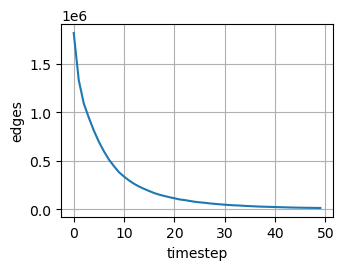

In [91]:
# pd.Series(
#     data=[get_subgraph_by_timestep(train_hg, t)["admission", "did", "labitem"].edge_index.shape[-1] for t in range(50)],
#     index=range(50)
# ).plot(kind='line', figsize=(3.5, 2.5), grid=True, ylabel="edges", xlabel="timestep")

# edge unique check

In [95]:
def check_unique_by_admission(subgraph, admission: int):
    mask_adm = (subgraph["admission", "did", "labitem"].edge_index[0] == admission)
    list_labitem = subgraph["admission", "did", "labitem"].edge_index[:, mask_adm][-1]
    
    return len(torch.unique(list_labitem)) == len(list_labitem)

# list_admission_labitem_not_unique_tiemstep_1 = [admission for admission in range(58976) if not check_unique_by_admission(sg, admission)]
# len(list_admission_labitem_not_unique_tiem step_1)

True